In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest




import ast
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Dense
from tensorflow.keras.models import load_model
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from keras.models import Sequential
from autoencoder_module import AutoEncoder
from Data import train_test_split_count_matrix_baseline, count_matrix, create_arrays_from_df_easier_v1 #, train_test_split_count_matrix_for_LSTM_easier_padding, train_test_split_count_matrix_for_LSTM
import h5py
from Analysis import roc_curve_for_analysis
from math import ceil
from typing import Tuple



In [ ]:
def create_arrays_from_df_easier_v2(data_df: pd.DataFrame, length_of_matrices: int=50) -> Tuple[np.array, np.array]:
    X, y = [], []
    for _, row in data_df.iterrows():
        seq = row['Event_Count_Matrix']
        label = row['label']
        if seq.shape[0] < length_of_matrices:
            helper_matrix = np.zeros((length_of_matrices, seq.shape[1]))
            helper_matrix[:seq.shape[0]] = seq
            helper_matrix[seq.shape[0]:] = seq[-1]
        if seq.shape[0] >= length_of_matrices:
            helper_matrix = seq[:length_of_matrices]
        X.append(helper_matrix)
        y.append(label)
    return np.array(X), np.array(y)



def train_test_split_count_matrix_for_LSTM_easier_padding(path: str, length_of_matrices: int, version: int=1,sequence_col: str = 'Event_Count_Matrix', label_col: str='label', test_size: float=0.2, random_state: int=42):
    #Loading in the data
    data_df = pd.read_csv(path)
    #Converting the labels to binary numbers, 0 for success, 1 for failure
    mask = data_df['Final Label'] == 'Success'
    data_df.loc[mask, 'label'] = 0
    data_df.loc[~mask, 'label'] = 1
    #I do not need the index column
    data_df = data_df.reset_index(drop=True)

    data_df['Events']  = data_df['New Event ID'].apply(ast.literal_eval)
    #Calculating the maximum value of the En type events
    max_n = max(int(e[1:]) for sublist in data_df['Events'] for e in sublist)
    data_df['Event_Count_Matrix'] = data_df['Events'].apply(lambda x: count_matrix(x, max_n))
    data_df.drop(columns=['Unnamed: 0', 'BlockId', 'New Event ID', 'Final Label', 'Events'], inplace=True)

    #Separate the dataframes based on the label and perform the train_test_split
    success_df = data_df.loc[data_df['label'] == 0].copy(deep=True)
    fail_df = data_df.loc[data_df['label'] == 1].copy(deep=True)
    train_success_df, test_success_df = train_test_split(success_df, test_size=test_size, shuffle=True, random_state=random_state)
    train_fail_df, test_fail_df = train_test_split(fail_df, test_size=test_size, shuffle=True, random_state=random_state)
    #Now concatenate the dataframes
    train_df = pd.concat([train_success_df, train_fail_df], ignore_index=True)
    test_df = pd.concat([test_success_df, test_fail_df], ignore_index=True)
    #Now let's perform the matrix creating magic
    if version == 1:
        X_train, y_train = create_arrays_from_df_easier_v1(train_df, length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v1(test_df, length_of_matrices)
    if version == 2:
        X_train, y_train = create_arrays_from_df_easier_v2(train_df[:10], length_of_matrices)
        X_test, y_test = create_arrays_from_df_easier_v2(test_df[:10], length_of_matrices)
    
    return X_train, X_test, y_train, y_test
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
length_of_matrices = 50
X_train, X_test, y_train, y_test = train_test_split_count_matrix_for_LSTM_easier_padding(path, length_of_matrices, version=2)


In [15]:
path = '../Data/HDFS_v1/Processed_data/processed_labeled_data.csv'
length_of_matrices = 50
X_train, X_test, y_train, y_test = train_test_split_count_matrix_for_LSTM_easier_padding(path, length_of_matrices, version=2)

In [17]:
np.shape(y_train)

(10,)

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, TimeDistributed, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(50,48), activation='tanh', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(TimeDistributed(Dense(1, activation='tanh')))
model.add(GlobalAveragePooling1D())  # Replaces Flatten()
#model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))  # Sigmoid is correct
optimizer = SGD(learning_rate=0.001)  # Changed from low-SGD
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='../Models/regularizedgrul2dropout.keras', save_best_only=True, verbose=1)

model.summary()

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 50)         │        15,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 50, 1)          │            51 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 1)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,053 (58.80 KB)

 Trainable params: 15,053 (58.80 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0246
Epoch 1: val_loss improved from 0.03457 to 0.03340, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0246 - val_loss: 0.0334
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0254
Epoch 2: val_loss improved from 0.03340 to 0.03221, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - loss: 0.0254 - val_loss: 0.0322
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0260
Epoch 3: val_loss improved from 0.03221 to 0.03104, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0260 - val_loss: 0.0310
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0262
Epoch 4: val_loss improved from 0.03104 to 0.02991, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 0.0262 - val_loss: 0.0299
Epoch 5/10
1/1 ━━━━━

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


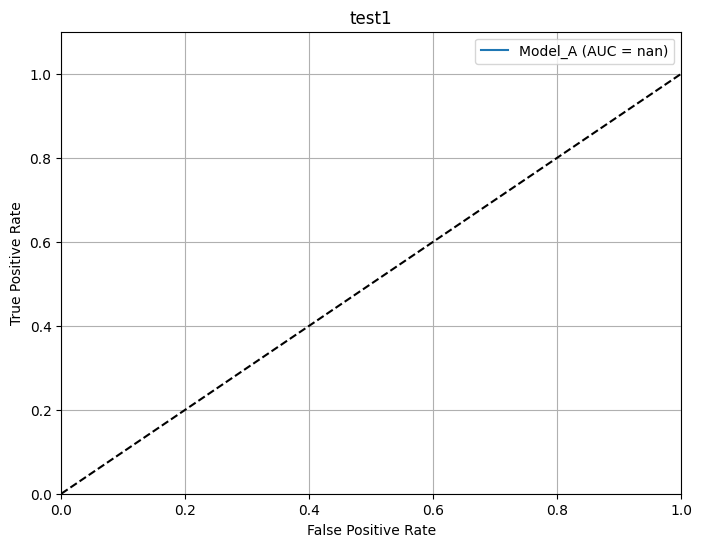

In [18]:
history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=10, 
                    validation_split=0.2,
                    batch_size=32,
                    callbacks=[checkpointer, early_stopping])

model.load_weights('../Models/regularizedgrul2dropout.keras')

result = model.predict(X_test)
roc_data = {
    "Model_A": {"scores": result, "labels": y_test}}
roc_curve_for_analysis((8,6), roc_data, 'test1', 'test.png', save = False)

In [19]:
np.sum(y_test)/len(y_test)

np.float64(0.023410381915075548)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0637
Epoch 1: val_loss improved from inf to 0.07277, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 0.0637 - val_loss: 0.0728
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0599
Epoch 2: val_loss improved from 0.07277 to 0.06840, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - loss: 0.0599 - val_loss: 0.0684
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.0561
Epoch 3: val_loss improved from 0.06840 to 0.06399, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.0561 - val_loss: 0.0640
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - loss: 0.0522
Epoch 4: val_loss improved from 0.06399 to 0.05953, saving model to ../Models/regularizedgrul2dropout.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step - loss: 0.0522 - val_loss: 0.0595
Epoch 5/10
1/1 ━━━━━━━━━━━

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\sklearn\metrics\_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


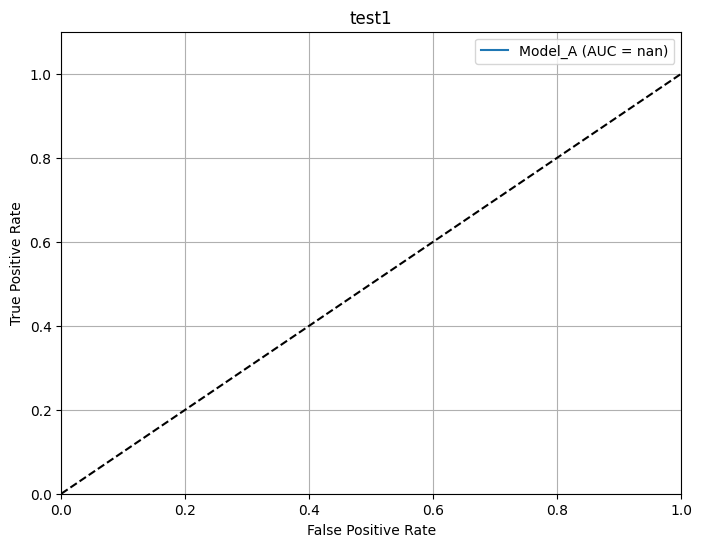

In [16]:
from keras.layers import Lambda, Flatten, Input
from tensorflow.keras import Model
from tensorflow.math import reduce_max, reduce_mean


input_layer = Input(shape=(50,48))
gru = GRU(10, return_sequences=True, activation='tanh')(input_layer)
timedistributed = TimeDistributed(Dense(1, activation='sigmoid'))(gru)
flatten=Flatten()(timedistributed)
max_val = Lambda(lambda x: reduce_max(x, axis=1))(flatten)
mean_val = Lambda(lambda x: reduce_mean(x, axis=1))(flatten)
difference_layer = Lambda(lambda x: x[0]-x[1])([max_val, mean_val])
model = Model(inputs=input_layer, outputs=difference_layer)
model.compile(loss='binary_crossentropy', optimizer='adam')


early_stopping = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='../Models/regularizedgrul2dropout.keras', save_best_only=True, verbose=1)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=10, 
                    validation_split=0.2,
                    callbacks=[checkpointer, early_stopping])

model.load_weights('../Models/regularizedgrul2dropout.keras')

result = model.predict(X_test)
roc_data = {
    "Model_A": {"scores": result, "labels": y_test}}
roc_curve_for_analysis((8,6), roc_data, 'test1', 'test.png', save = False)

c:\Users\mathb\Python\envs\diplomamunka\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 13, 250)        │       299,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 13, 1)          │           251 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 299,265 (1.14 MB)

 Trainable params: 299,265 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
21660/21662 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9989 - loss: 0.1593
Epoch 1: val_loss improved from inf to 0.56628, saving model to ../Models/regularizedgrul2dropout.keras
21662/21662 ━━━━━━━━━━━━━━━━━━━━ 464s 21ms/step - accuracy: 0.9989 - loss: 0.1593 - val_accuracy: 0.8791 - val_loss: 0.5663
Epoch 2/2
21660/21662 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0069
Epoch 2: val_loss did not improve from 0.56628
21662/21662 ━━━━━━━━━━━━━━━━━━━━ 469s 22ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.8791 - val_loss: 0.6524
6762/6762 ━━━━━━━━━━━━━━━━━━━━ 45s 7ms/step


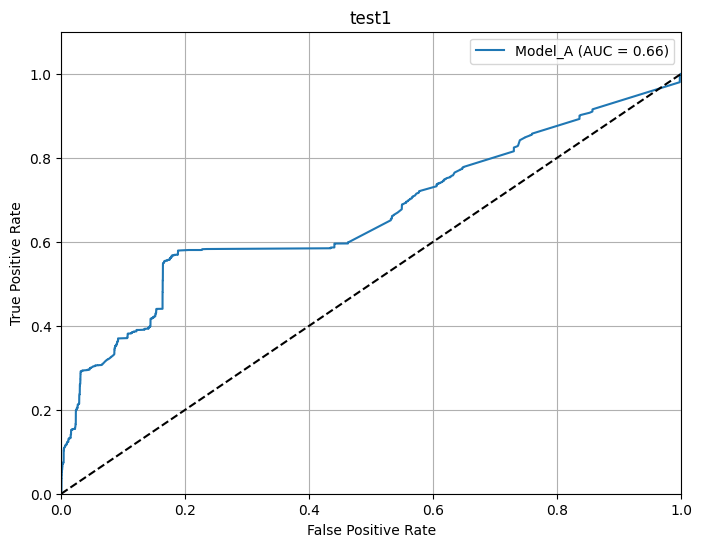

In [23]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, Flatten, TimeDistributed, MaxPool1D, Lambda, Input, Bidirectional, Dropout, LSTM
from tensorflow.math import reduce_max, reduce_mean
#import tensorflow_probability as tfp
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras import Model
from keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


#model = Sequential()
#model.add(GRU(10, return_sequences=True, input_shape=(13,48), activation='tanh')) #kernel_regularizer=l2(0.001)
#model.add(Dropout(0.1))
#model.add(TimeDistributed(Dense(1, activation='tanh')))
#model.add(Flatten())
#model.add(Dropout(0.1))
#model.add(Dense(1, activation='sigmoid'))
#optimizer = SGD(learning_rate=0.0001)

model = Sequential()
model.add(LSTM(250, return_sequences=True, input_shape=(13,48), activation='tanh'))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
optimizer = SGD(learning_rate=0.0005)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()
early_stopping = EarlyStopping(patience=10, verbose=1)
checkpointer = ModelCheckpoint(filepath='../Models/regularizedgrul2dropout.keras', save_best_only=True, verbose=1)

history = model.fit(x=X_train, 
                    y=y_train, 
                    epochs=2, 
                    validation_split=0.2,
                    callbacks=[checkpointer, early_stopping])


model.load_weights('../Models/regularizedgrul2dropout.keras')
result = model.predict(X_test)
roc_data = {
    "Model_A": {"scores": result, "labels": y_test}}
roc_curve_for_analysis((8,6), roc_data, 'test1', 'test.png', save = False)

In [20]:
len(X_train)

866443

In [20]:
model.load_weights('../Models/regularizedgrul2dropout.keras')
result = model.predict(X_test)

6762/6762 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step


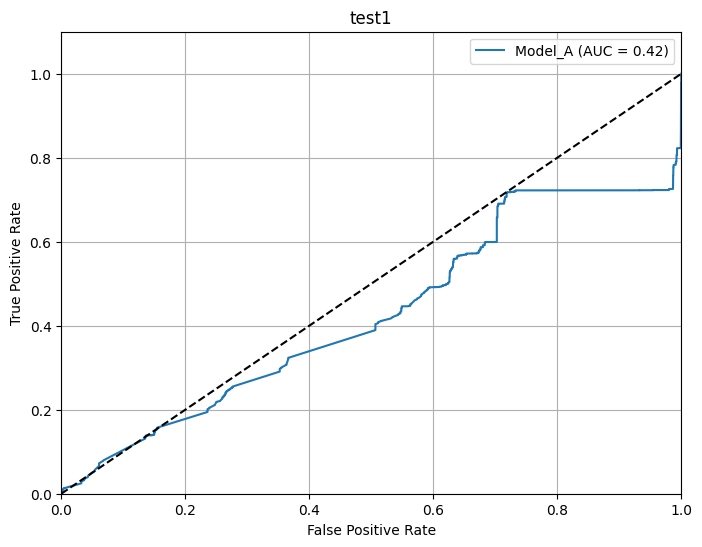

In [ ]:
model.load_weights('../Models/regularizedgrul2dropout.keras')
result = model.predict(X_test)
roc_data = {
    "Model_A": {"scores": result, "labels": y_test}}
roc_curve_for_analysis((8,6), roc_data, 'test1', 'test.png', save = False)

In [ ]:
result_dict = {'Result with GRU model': result, 'label': y_train}
result_df = pd.DataFrame(data = result_dict)


array([[0.00692178],
       [0.00728681],
       [0.0047218 ],
       [0.00668317],
       [0.0045319 ],
       [0.00687273],
       [0.00423428],
       [0.00664344],
       [0.00663601],
       [0.00456433]], dtype=float32)

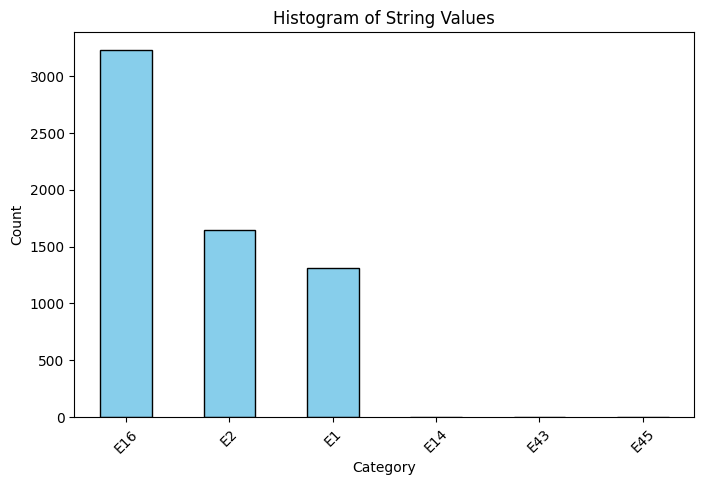

In [35]:
value_counts = problematic_df['last_event_code'].value_counts()

# Plot the histogram (bar plot)
plt.figure(figsize=(8, 5))
value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Histogram of String Values')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()